# Importing packages

In [1]:
import os
import numpy as np
import dxchange

import torch as tc
tc.set_default_tensor_type(tc.FloatTensor)
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import matplotlib 
matplotlib.rcParams['pdf.fonttype'] = 'truetype'
fontProperties = {'family': 'serif', 'serif': ['Helvetica'], 'weight': 'normal', 'size': 12}
plt.rc('font', **fontProperties)

from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mtick

from tqdm import tqdm
import xraylib as xlib
import xraylib_np as xlib_np
import time
import copy
import pickle

# Choose a device.
#### Not fully set up for a cuda device, choose cpu for now

In [2]:
# if tc.cuda.is_available():  
#     dev = "cuda:1" 
#     print("running on GPU")
# else:  
#     dev = "cpu"
#     print("running on CPU")

# device = tc.device(dev)
# print("device = %s" %device)

dev = "cpu"

# Setting up
1. experimental parameters
2. path of the true grid concentration of the sample
3. XRF and XRT data path
4. path to store the reconstrcting results

In [3]:
## For a 5 x 5 x 5 sample: sample3 ##
######################################################################
# experiemtal parameters #
theta_st = tc.tensor(0).to(dev)
theta_end = tc.tensor(2 * np.pi).to(dev)
n_theta =  tc.tensor(16).to(dev)
theta_ls = - tc.linspace(theta_st, theta_end, n_theta+1)[:-1].to(dev)
sample_size_n = tc.tensor(5).to(dev)
sample_height_n = tc.tensor(5).to(dev)
sample_size_cm = tc.tensor(0.01).to(dev)
this_aN_dic = {"C": 6, "O": 8, "Si": 14, "Ca": 20, "Fe": 26}
probe_energy = np.array([20.0])
probe_cts = tc.tensor(1.0E7).to(dev)
det_size_cm = 0.24
det_from_sample_cm = 1.6
det_ds_spacing_cm = 0.1

# path of true grid concentration of the sample #
grid_path = './data/sample3_pad'
f_grid = 'grid_concentration.npy'

# XRF and XRT data path #
data_path = './data/sample3_data'
f_XRF_data = 'XRF_sample3'
f_XRT_data = 'XRT_sample3'

# path of storing the intersecting information and the reconstructing results #
recon_path = 'data/sample3_recon'
P_save_path = os.path.join(recon_path, 'Intersecting_Length_5_5_5')
f_recon_parameters = 'recon_parameters.txt'
f_recon_grid = 'grid_concentration'
f_initial_guess = 'initialized_grid_concentration'
######################################################################

#  A quick view of the XRF data
#### Changeing the line index to see the signal of different XRF lines

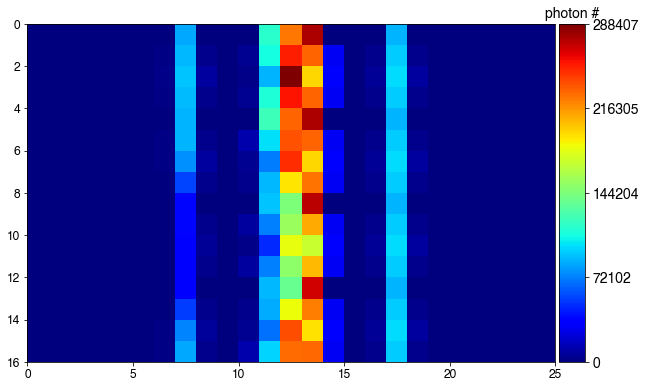

In [4]:
line_idx = 6

XRF_data = np.array([np.load(os.path.join(data_path, f_XRF_data)+'_{}'.format(i) + '.npy').astype(np.float32) for i in range(16)])
XRF_data_max = np.max(XRF_data[:,line_idx,:])
XRF_data_min = np.min(XRF_data[:,line_idx,:])


fig6 = plt.figure(figsize=(10,10))
gs6 = gridspec.GridSpec(nrows=1, ncols=1)

fig6_ax1 = fig6.add_subplot(gs6[0,0])
pos = fig6_ax1.imshow(XRF_data[:,line_idx,:], cmap='jet', vmin=0, vmax=XRF_data_max, extent=[0, 25, 16, 0], origin='upper')
divider = make_axes_locatable(fig6_ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
ticks = np.linspace(0, XRF_data_max, 5)
cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
cbar.ax.tick_params(labelsize=14) 
cbar.ax.set_title('photon #', size='14')

XRF_data = tc.from_numpy(XRF_data)

#  A quick view of the XRT data

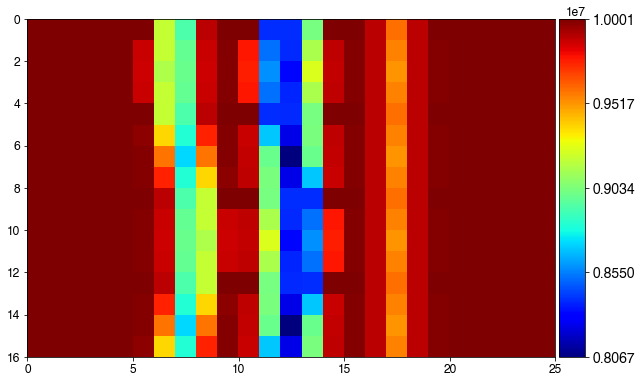

In [5]:
XRT_data = np.load(os.path.join(data_path, f_XRT_data + '.npy')).astype(np.float32)

fig6 = plt.figure(figsize=(10,10))
gs6 = gridspec.GridSpec(nrows=1, ncols=1)

fig6_ax1 = fig6.add_subplot(gs6[0,0])
pos = fig6_ax1.imshow(XRT_data, cmap='jet', vmin=np.min(XRT_data-1000), vmax=np.max(XRT_data+1000), extent=[0, 25, 16, 0], origin='upper')
divider = make_axes_locatable(fig6_ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
ticks = tc.linspace(np.min(XRT_data-1000), np.max(XRT_data)+1000, 5)
cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
cbar.ax.tick_params(labelsize=14) 
# cbar.ax.set_title('intensity', size='14')

XRT_data = tc.from_numpy(XRT_data)

# Defulf variables and functions

In [6]:
# xraylib uses keV
fl_K = np.array([xlib.KA1_LINE, xlib.KA2_LINE, xlib.KA3_LINE, xlib.KB1_LINE, xlib.KB2_LINE,
                 xlib.KB3_LINE, xlib.KB4_LINE, xlib.KB5_LINE])

fl_L = np.array([xlib.LA1_LINE, xlib.LA2_LINE, xlib.LB1_LINE, xlib.LB2_LINE, xlib.LB3_LINE,
                 xlib.LB4_LINE, xlib.LB5_LINE, xlib.LB6_LINE, xlib.LB7_LINE, xlib.LB9_LINE,
                 xlib.LB10_LINE, xlib.LB15_LINE, xlib.LB17_LINE])

fl_M = np.array([xlib.MA1_LINE, xlib.MA2_LINE, xlib.MB_LINE])

fl_line_groups = np.array(["K", "L", "M"])
group_lines = True

In [7]:
def MakeFLlinesDictionary(this_aN_dic, probe_energy,
                          sample_size_n, sample_size_cm,
                          fl_line_groups = np.array(["K", "L", "M"]), fl_K = fl_K, fl_L = fl_L, fl_M = fl_M,
                          group_lines = True):
    """   
    Parameters
    ----------
    this_aN_dic: dictionary
        a dictionary of items with key = element symbol (string), and value = atomic number
        e.g. this_aN_dic = {"C":6, "O": 8}

    probe_energy : ndarray
        This array is an array with only 1 element. The element is the keV energy of the incident beam.

    sample_size_n: int scalar
        sample size in number of pixles on one side, assuing a square sample of N x N pixels

    sample_size_cm: scalar
        sample size in cm

    fl_line_groups : ndarray, optional
        DESCRIPTION. The default is np.array(["K", "L", "M"]).

    fl_K : ndarray, optional
        The default is fl_K, an array of sub-lines of K line with the required format by xraylib.

    fl_L : ndarray, optional
        The default is fl_L, an array of sub-lines of L line with the required format by xraylib.

    fl_M : ndarray, optional
        The default is fl_M, an array of sub-lines of M line with the required format by xraylib.

    group_lines : boolean, optional
        Whether treating all K (or L, M) sub-lines as a single line. The default is True.

    Returns
    -------
    FL_all_elements_dic : dictionary
        The dictionary has 3 items. 
        1st item 
        key: "(element_name, Line)"
        value: an ndarray of ndarrays of 2 elements(type: string), [element symbol, line group]
        e.g. [['C', 'K'], ['O', 'K'], ['Si', 'K'], ['Si', 'L']]

        2nd item
        key: "fl_energy"
        value: float, Fluorescence energy in keV for each line of all element

        3rd item: "detected_fl_unit_concentration"
        key: fluorescence yield assuming a unit concentration [1 g/cm^3 ]
    """

    element_ls = np.array(list(this_aN_dic.keys()))
    aN_ls = np.array(list(this_aN_dic.values()))

    n_line_group = len(fl_line_groups)
    FL_all_elements_dic = {"element_Line": [], "fl_energy": np.array([]), "detected_fl_unit_concentration": np.array([])}
    voxel_size = sample_size_cm/sample_size_n   

    fl_cs_K = xlib_np.CS_FluorLine_Kissel_Cascade(aN_ls, fl_K, probe_energy)
    fl_cs_L = xlib_np.CS_FluorLine_Kissel_Cascade(aN_ls, fl_L, probe_energy)
    fl_cs_M = xlib_np.CS_FluorLine_Kissel_Cascade(aN_ls, fl_M, probe_energy)

    # Remove the extra dimension with only 1 element
    fl_cs_K = np.reshape(fl_cs_K, (fl_cs_K.shape[:-1]))
    fl_cs_L = np.reshape(fl_cs_L, (fl_cs_L.shape[:-1]))
    fl_cs_M = np.reshape(fl_cs_M, (fl_cs_M.shape[:-1]))

    fl_energy_K = xlib_np.LineEnergy(aN_ls, fl_K)
    fl_energy_L = xlib_np.LineEnergy(aN_ls, fl_L)
    fl_energy_M = xlib_np.LineEnergy(aN_ls, fl_M)

    FL_all_elements_dic = {"(element_name, Line)": [], "fl_energy": np.array([]), "detected_fl_unit_concentration": np.array([]),
                           "n_line_group_each_element": np.array([]), "n_lines": None}
    if group_lines == True:
        fl_energy_group = np.zeros((len(element_ls),n_line_group))
        fl_cs_group = np.zeros((len(element_ls),n_line_group))
        for i, element_name in enumerate(element_ls): 

            if np.sum(fl_cs_K[i] != 0):
                fl_energy_group[i,0] = np.average(fl_energy_K[i], weights=fl_cs_K[i]) 
                fl_cs_group[i,0] = np.sum(fl_cs_K[i])
            else:
                fl_energy_group[i,0] = 0
                fl_cs_group[i,0] = 0

            if np.sum(fl_cs_L[i] != 0):
                fl_energy_group[i,1] = np.average(fl_energy_L[i], weights=fl_cs_L[i]) 
                fl_cs_group[i,1] = np.sum(fl_cs_L[i])
            else:
                fl_energy_group[i,1] = 0
                fl_cs_group[i,1] = 0

            if np.sum(fl_cs_M[i] != 0):
                fl_energy_group[i,2] = np.average(fl_energy_M[i], weights=fl_cs_M[i]) 
                fl_cs_group[i,2] = np.sum(fl_cs_M[i])
            else:
                fl_energy_group[i,2] = 0
                fl_cs_group[i,2] = 0

            element_Line = fl_line_groups[fl_energy_group[i]!= 0]
            element_Line = [[element_name, element_Line[j]] for j in range(len(element_Line))]
            for k in range(len(element_Line)):
                FL_all_elements_dic["(element_name, Line)"].append(element_Line[k])     

            Line_energy = fl_energy_group[i][fl_energy_group[i]!=0]
            FL_all_elements_dic["fl_energy"] = np.append(FL_all_elements_dic["fl_energy"], Line_energy)
            fl_unit_con = fl_cs_group[i][fl_energy_group[i]!=0] * voxel_size
            FL_all_elements_dic["detected_fl_unit_concentration"] = np.append(FL_all_elements_dic["detected_fl_unit_concentration"], fl_unit_con)
            FL_all_elements_dic["n_line_group_each_element"] = np.append(FL_all_elements_dic["n_line_group_each_element"], len(fl_unit_con))
            
        FL_all_elements_dic["(element_name, Line)"] = np.array(FL_all_elements_dic["(element_name, Line)"])
    
    FL_all_elements_dic["n_lines"] = len(FL_all_elements_dic["(element_name, Line)"])
    return FL_all_elements_dic

In [8]:
def rotate(arr, theta, dev):
    m0 = tc.tensor([tc.cos(theta), -tc.sin(theta), 0.0], device=dev)
    m1 = tc.tensor([tc.sin(theta), tc.cos(theta), 0.0], device=dev)
    m = tc.stack([m0, m1]).view(1, 2, 3)
    m = m.repeat([arr.shape[0], 1, 1])
    
    g = F.affine_grid(m, arr.shape)
    q = F.grid_sample(arr, g, padding_mode='border')
    
    return q

In [9]:
### This cell solves the intersection of a ray with a plane 
### There're 3 types of plane x = some constant (d_x), y = some constant (d_y) and z = some constant (d_z)
### The correspoinding intersecting points can be solved using trace_beam_x, trace_beam_y, trace_beam_z respectively

# The ray using a parametric form with a parameter, t: R(t) = (1-t) * S + t * D 
# The intersecting coordinates: (x, y, z) = (Ix, Iy, Iz) at t=t*

# Define the system of equation AX = b to solve the intersecting, A is with the dimension: (n_batch, 4, 4), b is with the dimension: (n_batch, 4, 1)
# n_batch is the number of planes we put into the equation that we want to solve the intersecting point with the the ray

def trace_beam_z(z_s, x_s, y_s, z_d, x_d, y_d, d_z_ls):
    if len(d_z_ls) == 0 or z_s == z_d:
        Z = np.stack((np.array([]), np.array([]), np.array([])), axis=-1)
    else:
        A = tc.tensor([[1, 0, 0, z_s - z_d],[0, 1, 0, x_s - x_d],[0, 0, 1, y_s - y_d],[1, 0, 0, 0]])
        A = A.repeat([len(d_z_ls), 1, 1])

        b1 = tc.tensor([[[z_s], [x_s], [y_s]]]).repeat([len(d_z_ls), 1, 1])
        b2 = tc.tensor([[[d_z]] for d_z in d_z_ls])
        b = tc.cat((b1, b2), dim=1)

        Z, LU = tc.solve(b, A)
        Z = np.array(Z[:,:-1].view(len(d_z_ls), 3))
#         t = X[:,-1] 
    
    return Z

def trace_beam_x(z_s, x_s, y_s, z_d, x_d, y_d, d_x_ls):
    if len(d_x_ls) == 0:
        X = np.stack((np.array([]), np.array([]), np.array([])), axis=-1)
    else:    
        A = tc.tensor([[1, 0, 0, z_s - z_d],[0, 1, 0, x_s - x_d],[0, 0, 1, y_s - y_d],[0, 1, 0, 0]])
        A = A.repeat([len(d_x_ls), 1, 1])

        b1 = tc.tensor([[[z_s], [x_s], [y_s]]]).repeat([len(d_x_ls), 1, 1])
        b2 = tc.tensor([[[d_x]] for d_x in d_x_ls])
        b = tc.cat((b1, b2), dim=1)

        X, LU = tc.solve(b, A)
        X = np.array(X[:,:-1].view(len(d_x_ls), 3))
#         t = Y[:,-1]
    
    return X

def trace_beam_y(z_s, x_s, y_s, z_d, x_d, y_d, d_y_ls):
    if len(d_y_ls) == 0 or y_s == y_d:
        Y = np.stack((np.array([]), np.array([]), np.array([])), axis=-1)
    else:
        A = tc.tensor([[1, 0, 0, z_s - z_d],[0, 1, 0, x_s - x_d],[0, 0, 1, y_s - y_d],[0, 0, 1, 0]])
        A = A.repeat([len(d_y_ls), 1, 1])

        b1 = tc.tensor([[[z_s], [x_s], [y_s]]]).repeat([len(d_y_ls), 1, 1])
        b2 = tc.tensor([[[d_y]] for d_y in d_y_ls])
        b = tc.cat((b1, b2), dim=1)

        Y, LU = tc.solve(b, A)
        Y = np.array(Y[:,:-1].view(len(d_y_ls), 3))
#         t = Z[:,-1]
    
    return Y

In [10]:
def intersecting_length_fl_detectorlet_3d(det_size_cm, det_from_sample_cm, det_ds_spacing_cm, sample_size_n, sample_size_cm, sample_height_n, P_save_path):
    if os.path.isfile(P_save_path):
        with open(P_save_path, "rb") as myFile:
            P = pickle.load(myFile)
        n_det = P.shape[0]
        
    
    else:
        ### Calculating voxel size in cm
        voxel_size_cm = sample_size_cm/sample_size_n

        ### Calculating the diameter of the XRF detector with 
        det_size_n = int(np.ceil(det_size_cm/voxel_size_cm)) 

        ### Set the desired spacing between detectorlets, and then convert the unit of spacing to the number of the sample voxels
        det_ds_spacing_cm = 0.1
        det_ds_spacing_n = int(det_ds_spacing_cm/voxel_size_cm)

        # Define position of center of the source voxel (z_s, x_s, y_s), note that it's shifted by 0.5 from the voxel idx to represent the loc of center
        z_s, x_s, y_s = np.indices((int(sample_height_n), int(sample_size_n), int(sample_size_n))) + 0.5
        voxel_pos_ls_flat = np.stack((z_s.flatten(), x_s.flatten(), y_s.flatten()), axis=-1)


        ### Define the location of the detectorlets, the detector is parallel to the yz-plane
        ### The x-posision depends on the distance between the sample and the detecor
        ## x index of the location of the XRF detector
        det_axis_1_idx = sample_size_n + np.ceil(det_from_sample_cm/voxel_size_cm) + 0.5

        ### y, z index of the location of the XRF detector
        ## Define the center of the detector on yz-plane
        det_center_yz = (int(sample_size_n)/2., int(sample_size_n)/2.)

        ## Define the y and z loc(namely the loc along axis 2 and axis 0) of the detectorlets. The y and z loc are confined to be within a circle on the yz plane
        end_det_axis_2_idx_ls = np.array([int((sample_size_n - det_ds_spacing_n * np.floor(det_size_n/det_ds_spacing_n))/2.),
                                          int((sample_size_n + det_ds_spacing_n * np.floor(det_size_n/det_ds_spacing_n))/2.)])

        det_axis_2_idx_ls = np.linspace(end_det_axis_2_idx_ls[0], end_det_axis_2_idx_ls[1], np.int(det_size_n/det_ds_spacing_n + 1))


        end_det_axis_0_idx_ls = np.array([int((sample_height_n - det_ds_spacing_n * np.floor(det_size_n/det_ds_spacing_n))/2.),
                                          int((sample_height_n + det_ds_spacing_n * np.floor(det_size_n/det_ds_spacing_n))/2.)])

        det_axis_0_idx_ls = np.linspace(end_det_axis_0_idx_ls[0], end_det_axis_0_idx_ls[1], np.int(det_size_n/det_ds_spacing_n + 1))

        ## Create the meshgrid of y and z coordinates and keep only the coordinates within the detector circle
        y_d, z_d = np.meshgrid(det_axis_2_idx_ls, det_axis_0_idx_ls)

        yz_mask = ((y_d - det_center_yz[0])**2 + (z_d - det_center_yz[1])**2 <= (det_size_n/2)**2).flatten()
        y_d_flat, z_d_flat = y_d.flatten()[yz_mask], z_d.flatten()[yz_mask]


        ## The number of x posision needed to fill into the coodinates depends on the number of the y(or z) coodinates within the circle of detector
        x_d_flat = np.full((y_d_flat.shape), det_axis_1_idx)

        ##
        det_pos_ls_flat = np.stack((z_d_flat, x_d_flat, y_d_flat), axis=-1)
        n_det = len(det_pos_ls_flat)

        ## define sample edges: 
        ## sample_x_edge is the edge that is closer to the XRF detector
        ## sample_y_edge has two components representing the left and the right edge
        sample_x_edge = np.array([sample_size_n])
        sample_y_edge = np.array([0, sample_size_n]) 
        sample_z_edge = np.array([0, sample_height_n]) 

        # P = np.zeros((n_det, sample_height_n * sample_size_n * sample_size_n, sample_height_n * sample_size_n * sample_size_n), dtype=np.float32)
        dia_len_n = int((sample_height_n**2 + sample_size_n**2 + sample_size_n**2)**0.5)
        P = tc.zeros(n_det, 3, dia_len_n * sample_height_n * sample_size_n**2)
#         Q = tc.zeros(3, sample_height_n * sample_size_n**2 * dia_len_n)
        
        for i,  det_pos in enumerate(det_pos_ls_flat):
            for j, v in enumerate(tqdm(voxel_pos_ls_flat)): 

                # Solving the intersection of the ray with the sample boundary along axis-0
                bdx_int = trace_beam_x(v[0], v[1], v[2], det_pos[0], det_pos[1], det_pos[2], sample_x_edge) # pick the 0th component just because the coordinate is doubly braced

                # Solving the intersection of the ray with the sample boundaries along axis-1 and axis-2, we will get 2 solutions for each axis since there're 2 bdry plane on each axis
                # The desired intersecting point is within the segment(voxel - detectorlet) which is always the one with the larger x coordinate
                bdy_int = trace_beam_y(v[0], v[1], v[2], det_pos[0], det_pos[1], det_pos[2], sample_y_edge)
                if len(bdy_int) != 0:
                    bdy_int = np.array([bdy_int[np.argmax(bdy_int[:,1])]])
                else:
                    pass


                bdz_int = trace_beam_z(v[0], v[1], v[2], det_pos[0], det_pos[1], det_pos[2], sample_z_edge)
                if len(bdz_int) != 0:
                    bdz_int = np.array([bdz_int[np.argmax(bdz_int[:,1])]])
                else:
                    pass

                # Pick the intersecting point that first hit the boundary plan. This point is with the least x value among the 3 intersections.
                bd_int_ls = np.concatenate((bdz_int, bdx_int, bdy_int))
                bd_int = np.clip(np.abs((bd_int_ls[np.argmin(bd_int_ls[:,1])])), 0, sample_size_n)


                # when the beam intersects with a voxel, it either intersects with the x or y or z boundary plane of the voxel
                # find the x,y,z-value of the voxel boundary except the ones on the sample edge

                z_edge_ls = np.where(bd_int[0] > v[0], np.linspace(np.ceil(bd_int[0])-1, np.ceil(v[0]), int(np.abs(np.ceil(bd_int[0]) - np.ceil(v[0])))),
                                                       np.linspace(np.ceil(v[0])-1, np.ceil(bd_int[0]), int(np.abs(np.ceil(bd_int[0]) - np.ceil(v[0])))))

                x_edge_ls = np.where(bd_int[1] > v[1], np.linspace(np.ceil(bd_int[1])-1, np.ceil(v[1]), int(np.abs(np.ceil(bd_int[1]) - np.ceil(v[1])))),
                                                       np.linspace(np.ceil(v[1])-1, np.ceil(bd_int[1]), int(np.abs(np.ceil(bd_int[1]) - np.ceil(v[1])))))

                y_edge_ls = np.where(bd_int[2] > v[2], np.linspace(np.ceil(bd_int[2])-1, np.ceil(v[2]), int(np.abs(np.ceil(bd_int[2]) - np.ceil(v[2])))),
                                                       np.linspace(np.ceil(v[2])-1, np.ceil(bd_int[2]), int(np.abs(np.ceil(bd_int[2]) - np.ceil(v[2])))))


                z_edge_int_ls = trace_beam_z(v[0], v[1], v[2], det_pos[0], det_pos[1], det_pos[2], z_edge_ls)
                x_edge_int_ls = trace_beam_x(v[0], v[1], v[2], det_pos[0], det_pos[1], det_pos[2], x_edge_ls)
                y_edge_int_ls = trace_beam_y(v[0], v[1], v[2], det_pos[0], det_pos[1], det_pos[2], y_edge_ls)

                # Collect all intersecting points and sort all intersections using the x coordinate
                int_ls = np.concatenate((x_edge_int_ls, y_edge_int_ls, z_edge_int_ls, np.array(bd_int)[np.newaxis,:]))     
                int_ls = int_ls[np.argsort(int_ls[:,1])]

                # calculate the intersecting length in the intersecting voxels
                int_length = np.sqrt(np.diff(int_ls[:,0])**2 + np.diff(int_ls[:,1])**2 + np.diff(int_ls[:,2])**2)
                # just in case that we count some intersections twice, delete the duplicates
                idx_duplicate = np.array(np.where(int_length==0)).flatten()
                int_ls = np.delete(int_ls, idx_duplicate, 0)
                int_length = np.delete(int_length, idx_duplicate) 

                # determine the indices of the intersecting voxels according to the intersecting x,y,z-coordinates
                int_ls_shift = np.zeros((int_ls.shape))
                int_ls_shift[1:] = int_ls[:-1]
                int_idx = np.floor((int_ls + int_ls_shift)/2)[1:]
#                 int_idx = (int_idx[:,0].astype('int'), int_idx[:,1].astype('int'), int_idx[:,2].astype('int'))
                int_idx_flat = int_idx[:,0] * (sample_height_n.item() * sample_size_n.item()) + int_idx[:,1] * sample_size_n.item() + int_idx[:,2]
    
                
                P[i, 0, j * dia_len_n: j * dia_len_n + len(int_idx_flat)] = j
                P[i, 1, j * dia_len_n: j * dia_len_n + len(int_idx_flat)] = tc.tensor(int_idx_flat)
                P[i, 2, j * dia_len_n: j * dia_len_n + len(int_idx_flat)] = tc.tensor(int_length * voxel_size_cm.item())            

                                
                tqdm._instances.clear()
                      
        with open(P_save_path, "wb") as myFile:
            pickle.dump(P, myFile)
    return n_det, P

# Forward model
#### for the 1st epoch

In [109]:
class PPM(nn.Module):
    
    fl_line_groups=np.array(["K", "L", "M"]) 
    fl_K=fl_K
    fl_L=fl_L
    fl_M=fl_M
    group_lines=True
    
    def __init__(self, ini_kind, const, grid_concentration, p, n_element, sample_height_n, minibatch_size, sample_size_n, sample_size_cm,
                 this_aN_dic, probe_energy, probe_cts, fl_line_groups, fl_K, fl_L, fl_M, group_lines, 
                 theta_st, theta_end, n_theta, this_theta_idx,
                 det_ds_spacing_cm, det_size_cm, det_from_sample_cm, P_save_path):
        """
        Initialize the attributes of PPM. 
        """
        super(PPM, self).__init__() # inherit the __init__ from nn.Module.
        self.ini_kind = ini_kind
        self.const = const
        self.grid_concentration = grid_concentration
        self.theta_ls = - tc.linspace(theta_st, theta_end, n_theta+1)[:-1]
        self.this_theta_idx = this_theta_idx
        self.n_element = n_element
        self.sample_height_n = sample_height_n
        self.minibatch_size = minibatch_size
        self.sample_size_n = sample_size_n
        self.p = p  # indicate which minibatch to calculate the gradient  
        self.xp = self.init_xp() # initialize the values of the minibatch
        
        self.probe_energy = probe_energy  
        self.this_aN_dic = this_aN_dic
        self.n_element = tc.as_tensor(len(self.this_aN_dic)).to(dev)
        self.element_ls = np.array(list(this_aN_dic.keys()))
        self.aN_ls = np.array(list(this_aN_dic.values()))
        
        self.probe_attCS_ls = tc.as_tensor(xlib_np.CS_Total(self.aN_ls, self.probe_energy).flatten()).to(dev)
#         self.probe_attCS_dic = dict(zip(self.element_ls, self.probe_attCS_ls))
        
        self.sample_size_cm = sample_size_cm
        self.fl_line_groups = fl_line_groups
        self.fl_K = fl_K
        self.fl_L = fl_L
        self.fl_M = fl_M
        self.group_lines = group_lines
        self.fl_all_lines_dic = self.init_fl_all_lines_dic()
        self.n_lines = tc.as_tensor(self.fl_all_lines_dic["n_lines"]).to(dev)
        self.FL_line_attCS_ls = tc.as_tensor(xlib_np.CS_Total(self.aN_ls, self.fl_all_lines_dic["fl_energy"])).float().to(dev)
        self.detected_fl_unit_concentration = tc.as_tensor(self.fl_all_lines_dic["detected_fl_unit_concentration"]).float().to(dev)
        self.n_line_group_each_element = tc.IntTensor(self.fl_all_lines_dic["n_line_group_each_element"]).to(dev)
        
        self.dia_len_n = int((self.sample_height_n**2 + self.sample_size_n**2 + self.sample_size_n**2)**0.5)
        self.n_voxel_batch = self.minibatch_size * self.sample_size_n
        self.n_voxel = self.sample_height_n * self.sample_size_n**2   
        
        self.det_ds_spacing_cm = det_ds_spacing_cm
        self.det_size_cm = det_size_cm
        self.det_from_sample_cm = det_from_sample_cm
        self.P_save_path = P_save_path
        
        self.n_det, self.P_batch = self.init_intersecting_length_fl_detectorlet()  
        
        self.probe_cts = probe_cts
        self.probe_before_attenuation_flat = self.init_probe()

        
    def init_xp(self):
        """
        Initialize self.xp with the tensor of the true model(noise may already be added) (n_element, minibatch_size, n_y)
        """
        if self.ini_kind == "rand" or self.ini_kind == "randn":
            theta = self.theta_ls[self.this_theta_idx]
            concentration_map_rot = rotate(self.grid_concentration, theta, dev).view(self.n_element, self.sample_height_n * self.sample_size_n, self.sample_size_n)
            return nn.Parameter(concentration_map_rot[:, self.minibatch_size * self.p : self.minibatch_size*(self.p+1), :])
        
        if self.ini_kind == "const":        
            return nn.Parameter(tc.zeros(self.n_element, self.minibatch_size, self.sample_size_n) + self.const)

    def init_fl_all_lines_dic(self):
        """
        Initialize self.fl_all_lines_dic
        """
        fl_all_lines_dic = MakeFLlinesDictionary(self.this_aN_dic, self.probe_energy,
                      self.sample_size_n.cpu().numpy(), self.sample_size_cm.cpu().numpy(),
                      self.fl_line_groups, self.fl_K, self.fl_L, self.fl_M,
                      self.group_lines)
        return fl_all_lines_dic
    
    def init_intersecting_length_fl_detectorlet(self):
        """
        Initialize self.intersecting_length_fl_detectorlet
        """
        n_det, P = intersecting_length_fl_detectorlet_3d(self.det_size_cm, self.det_from_sample_cm, self.det_ds_spacing_cm,
                                                  self.sample_size_n.cpu().numpy(), self.sample_size_cm.cpu().numpy(),
                                                  self.sample_height_n.cpu().numpy(), self.P_save_path)
   
        P = P.float().to(dev)
#         print(P.shape)
        
        P_batch = P.view(n_det, 3, self.dia_len_n * self.sample_height_n * self.sample_size_n, self.sample_size_n)
        P_batch = P_batch[:, :, self.dia_len_n * self.minibatch_size * self.p : self.dia_len_n * self.minibatch_size * (self.p+1), :]
        P_batch = P_batch.view(n_det, 3, self.dia_len_n * self.minibatch_size * self.sample_size_n)

        return n_det, P_batch
    
    def init_probe(self):
        return self.probe_cts * tc.ones((self.minibatch_size * self.sample_size_n), device=dev)
    
    def forward(self, grid_concentration, this_theta_idx): 
        start_time = time.time()
        """
        Forward propagation.
        """      
        
        ### 1: Calculate the map of attenuation and transmission ###          
        theta = self.theta_ls[this_theta_idx]

        # Rotate the sample
        concentration_map_rot = rotate(grid_concentration, theta, dev).view(self.n_element, self.sample_height_n * self.sample_size_n, self.sample_size_n)
        
        # Set part of the sample to be the updating target
        concentration_map_rot[:, self.minibatch_size * self.p : self.minibatch_size*(self.p+1), :] = self.xp
        
        # Create a tensor to store the current batch of the sample
        concentration_map_rot_batch = concentration_map_rot[:, self.minibatch_size * self.p : self.minibatch_size*(self.p+1), :]
        
        ## Calculate the attenuation of the probe
        # Calculate the expoenent of attenuation of each voxel in the batch. (The atteuation before the probe enters each voxel.)
        att_exponent_acc_map = tc.zeros((self.minibatch_size, self.sample_size_n+1), device=dev)
        for j in range(self.n_element):
            lac_single = concentration_map_rot_batch[j] * self.probe_attCS_ls[j]
            lac_acc = tc.cumsum(lac_single, axis=1)
            lac_acc = tc.cat((tc.zeros((self.minibatch_size, 1), device=dev), lac_acc), dim = 1)
            att_exponent_acc = lac_acc * (self.sample_size_cm / self.sample_size_n)    
            att_exponent_acc_map += att_exponent_acc
            
        attenuation_map_theta_flat = tc.exp(-(att_exponent_acc_map[:,:-1])).view(self.n_voxel_batch)
        transmission_theta = tc.exp(-att_exponent_acc_map[:,-1])

        
        ### 2: Calculate the number of fluerescence photon of each line generated at each voxel given one incident photon
        fl_map_tot_flat_theta = tc.zeros((self.n_lines, self.n_voxel_batch), device=dev)        
        concentration_map_rot_batch_flat = concentration_map_rot_batch.view(self.n_element, self.n_voxel_batch)
        line_idx = 0
        for j in range(self.n_element):
            fl_unit = self.detected_fl_unit_concentration[line_idx:line_idx + self.n_line_group_each_element[j]]
            
            ## FL signal over the current elemental lines for each voxel
            fl_map = tc.stack([concentration_map_rot_batch_flat[j] * fl_unit_single_line for fl_unit_single_line in fl_unit])
            
            fl_map_tot_flat_theta[line_idx:line_idx + self.n_line_group_each_element[j],:] = fl_map            
            line_idx = line_idx + len(fl_unit)
            
        ### 3: Calculate SA (the map of attenuation ratio due to self-absorption of the FL signal):
        # 1. for each FL emitting source voxel (n_voxel_batch),
        # 2. we have an attenuation ratio when the photon for each elemental line reaches the edge of the sample (due to self absorption) (n_lines)
        # ==> The dimension of SA: (n_lines, n_voxel_batch)
              
        # First, Calaulting the exponent of attenuation: att_exponent
        # lac: linear attenuation coefficient = concentration * attenuation_cross_section, dimension: (n_element, n_lines, n_voxel_batch(FL source), n_voxel)  
           # For each voxel source in this batch, there're n_lines emitted XRF energy, each voxel in the sample contribute to the attenuation due to SA
        # FL_line_attCS_ls: an arrary of the attenuation cross section, dimension: (n_element, n_lines)
           # The component in the array represents the total attenuation cross section at some line energy in some element
               
        lac = concentration_map_rot.view(self.n_element, 1, 1, self.n_voxel) * self.FL_line_attCS_ls.view(self.n_element, self.n_lines, 1, 1)
        lac = lac.expand(-1, -1, self.n_voxel_batch, -1).float()
        
        voxel_idx_offset = self.p * self.n_voxel_batch
        
        att_exponent = tc.stack([lac[:,:, tc.clamp((self.P_batch[m,0] - voxel_idx_offset), 0, self.n_voxel_batch).to(dtype=tc.long), self.P_batch[m,1].to(dtype=tc.long)]
                                 * self.P_batch[m,2].view(1, 1, -1).repeat(self.n_element, self.n_lines, 1) for m in range(self.n_det)])
        
        ## summing over the attenation exponent contributed by all intersecting voxels, dim = (n_det, n_element, n_lines, n_voxel_batch(FL source))
        att_exponent_voxel_sum = tc.sum(att_exponent.view(self.n_det, self.n_element, self.n_lines, self.n_voxel_batch, self.dia_len_n), axis=-1)
        
        ## calculate the attenuation caused by all elements, dim = (n_det, n_lines, n_voxel_batch(FL source)), and then take the average over n_det FL paths
        SA_theta =  tc.mean(tc.exp(-tc.sum(att_exponent_voxel_sum, axis=1)), axis=0)        
        
              
        #### 4: Create XRF, XRT data ####           
        probe_after_attenuation_theta = self.probe_before_attenuation_flat * attenuation_map_theta_flat 
        fl_signal_SA_theta = tc.unsqueeze(probe_after_attenuation_theta, dim=0) * fl_map_tot_flat_theta * SA_theta  
        fl_signal_SA_theta = fl_signal_SA_theta.view(-1, self.minibatch_size, self.sample_size_n)
        fl_signal_SA_theta = tc.sum(fl_signal_SA_theta, axis=-1)
                       
        output1 = fl_signal_SA_theta
        output2 = probe_cts * transmission_theta
#         print("running_time = %.3f" %(time.time() - start_time))
        return output1, output2

# Forward model
#### after the 1st epoch

In [175]:
class PPM_cont(nn.Module):
    
    fl_line_groups=np.array(["K", "L", "M"]) 
    fl_K=fl_K
    fl_L=fl_L
    fl_M=fl_M
    group_lines=True
    
    def __init__(self, grid_concentration, p, n_element, sample_height_n, minibatch_size, sample_size_n, sample_size_cm,
                 this_aN_dic, probe_energy, probe_cts, fl_line_groups, fl_K, fl_L, fl_M, group_lines, 
                 theta_st, theta_end, n_theta, this_theta_idx,
                 det_ds_spacing_cm, det_size_cm, det_from_sample_cm, P_save_path):
        """
        Initialize the attributes of PPM. 
        """
        super(PPM_cont, self).__init__() # inherit the __init__ from nn.Module.
        self.grid_concentration = grid_concentration
        self.theta_ls = - tc.linspace(theta_st, theta_end, n_theta+1)[:-1]
        self.this_theta_idx = this_theta_idx
        self.n_element = n_element
        self.sample_height_n = sample_height_n
        self.minibatch_size = minibatch_size
        self.sample_size_n = sample_size_n
        self.p = p  # indicate which minibatch to calculate the gradient  
        self.xp = self.init_xp() # initialize the values of the minibatch
        
        self.probe_energy = probe_energy  
        self.this_aN_dic = this_aN_dic
        self.n_element = tc.as_tensor(len(self.this_aN_dic)).to(dev)
        self.element_ls = np.array(list(this_aN_dic.keys()))
        self.aN_ls = np.array(list(this_aN_dic.values()))
        
        self.probe_attCS_ls = tc.as_tensor(xlib_np.CS_Total(self.aN_ls, self.probe_energy).flatten()).to(dev)
#         self.probe_attCS_dic = dict(zip(self.element_ls, self.probe_attCS_ls))
        
        self.sample_size_cm = sample_size_cm
        self.fl_line_groups = fl_line_groups
        self.fl_K = fl_K
        self.fl_L = fl_L
        self.fl_M = fl_M
        self.group_lines = group_lines
        self.fl_all_lines_dic = self.init_fl_all_lines_dic()
        self.n_lines = tc.as_tensor(self.fl_all_lines_dic["n_lines"]).to(dev)
        self.FL_line_attCS_ls = tc.as_tensor(xlib_np.CS_Total(self.aN_ls, self.fl_all_lines_dic["fl_energy"])).float().to(dev)
        self.detected_fl_unit_concentration = tc.as_tensor(self.fl_all_lines_dic["detected_fl_unit_concentration"]).float().to(dev)
        self.n_line_group_each_element = tc.IntTensor(self.fl_all_lines_dic["n_line_group_each_element"]).to(dev)
        
        self.dia_len_n = int((self.sample_height_n**2 + self.sample_size_n**2 + self.sample_size_n**2)**0.5)
        self.n_voxel_batch = self.minibatch_size * self.sample_size_n
        self.n_voxel = self.sample_height_n * self.sample_size_n**2   
        
        self.det_ds_spacing_cm = det_ds_spacing_cm
        self.det_size_cm = det_size_cm
        self.det_from_sample_cm = det_from_sample_cm
        self.P_save_path = P_save_path
        
        self.n_det, self.P_batch = self.init_intersecting_length_fl_detectorlet()  
        
        self.probe_cts = probe_cts
        self.probe_before_attenuation_flat = self.init_probe()

        
    def init_xp(self):
        """
        Initialize self.x with the tensor of the saved intermediate reconstructing results (n_element, minibatch_size, n_y)
        """
        theta = self.theta_ls[self.this_theta_idx]
        concentration_map_rot = rotate(self.grid_concentration, theta, dev).view(self.n_element, self.sample_height_n * self.sample_size_n, self.sample_size_n)
        return nn.Parameter(concentration_map_rot[:, self.minibatch_size * self.p : self.minibatch_size*(self.p+1), :])

    def init_fl_all_lines_dic(self):
        """
        Initialize self.fl_all_lines_dic
        """
        fl_all_lines_dic = MakeFLlinesDictionary(self.this_aN_dic, self.probe_energy,
                      self.sample_size_n.cpu().numpy(), self.sample_size_cm.cpu().numpy(),
                      self.fl_line_groups, self.fl_K, self.fl_L, self.fl_M,
                      self.group_lines)
        return fl_all_lines_dic
    
    def init_intersecting_length_fl_detectorlet(self):
        """
        Initialize self.intersecting_length_fl_detectorlet
        """
        n_det, P = intersecting_length_fl_detectorlet_3d(self.det_size_cm, self.det_from_sample_cm, self.det_ds_spacing_cm,
                                                  self.sample_size_n.cpu().numpy(), self.sample_size_cm.cpu().numpy(),
                                                  self.sample_height_n.cpu().numpy(), self.P_save_path)
   
        P = P.float().to(dev)
#         print(P.shape)
        
        P_batch = P.view(n_det, 3, self.dia_len_n * self.sample_height_n * self.sample_size_n, self.sample_size_n)
        P_batch = P_batch[:, :, self.dia_len_n * self.minibatch_size * self.p : self.dia_len_n * self.minibatch_size * (self.p+1), :]
        P_batch = P_batch.view(n_det, 3, self.dia_len_n * self.minibatch_size * self.sample_size_n)

        return n_det, P_batch
    
    def init_probe(self):
        return self.probe_cts * tc.ones((self.minibatch_size * self.sample_size_n), device=dev)
    
    def forward(self, grid_concentration, this_theta_idx): 
        start_time = time.time()
        """
        Forward propagation.
        """      
        
        ### 1: Calculate the map of attenuation and transmission ###          
        theta = self.theta_ls[this_theta_idx]

        # Rotate the sample
        concentration_map_rot = rotate(grid_concentration, theta, dev).view(self.n_element, self.sample_height_n * self.sample_size_n, self.sample_size_n)
        
        # Set part of the sample to be the updating target
        concentration_map_rot[:, self.minibatch_size * self.p : self.minibatch_size*(self.p+1), :] = self.xp
        
        # Create a tensor to store the current batch of the sample
        concentration_map_rot_batch = concentration_map_rot[:, self.minibatch_size * self.p : self.minibatch_size*(self.p+1), :]
        
        ## Calculate the attenuation of the probe
        # Calculate the expoenent of attenuation of each voxel in the batch. (The atteuation before the probe enters each voxel.)
        att_exponent_acc_map = tc.zeros((self.minibatch_size, self.sample_size_n+1), device=dev)
        for j in range(self.n_element):
            lac_single = concentration_map_rot_batch[j] * self.probe_attCS_ls[j]
            lac_acc = tc.cumsum(lac_single, axis=1)
            lac_acc = tc.cat((tc.zeros((self.minibatch_size, 1), device=dev), lac_acc), dim = 1)
            att_exponent_acc = lac_acc * (self.sample_size_cm / self.sample_size_n)    
            att_exponent_acc_map += att_exponent_acc
            
        attenuation_map_theta_flat = tc.exp(-(att_exponent_acc_map[:,:-1])).view(self.n_voxel_batch)
        transmission_theta = tc.exp(-att_exponent_acc_map[:,-1])
        
        ### 2: Calculate the number of fluerescence photon of each line generated at each voxel given one incident photon
        fl_map_tot_flat_theta = tc.zeros((self.n_lines, self.n_voxel_batch), device=dev)
        concentration_map_rot_batch_flat = concentration_map_rot_batch.view(self.n_element, self.n_voxel_batch)
        line_idx = 0
        for j in range(self.n_element):
            fl_unit = self.detected_fl_unit_concentration[line_idx:line_idx + self.n_line_group_each_element[j]]
            
            ## FL signal over the current elemental lines for each voxel
            fl_map = tc.stack([concentration_map_rot_batch_flat[j] * fl_unit_single_line for fl_unit_single_line in fl_unit])
            
            fl_map_tot_flat_theta[line_idx:line_idx + self.n_line_group_each_element[j],:] = fl_map            
            line_idx = line_idx + len(fl_unit)
            
        ### 3: Calculate SA (the map of attenuation ratio due to self-absorption of the FL signal):
        # 1. for each FL emitting source voxel (n_voxel_batch),
        # 2. we have an attenuation ratio when the photon for each elemental line reaches the edge of the sample (due to self absorption) (n_lines)
        # ==> The dimension of SA: (n_lines, n_voxel_batch)
        
        
        # First, Calaulting the exponent of attenuation: att_exponent
        # lac: linear attenuation coefficient = concentration * attenuation_cross_section, dimension: (n_element, n_lines, n_voxel_batch(FL source), n_voxel)  
           # For each voxel source in this batch, there're n_lines emitted XRF energy, each voxel in the sample contribute to the attenuation due to SA
        # FL_line_attCS_ls: an arrary of the attenuation cross section, dimension: (n_element, n_lines)
           # The component in the array represents the total attenuation cross section at some line energy in some element
               
        lac = concentration_map_rot.view(self.n_element, 1, 1, self.n_voxel) * self.FL_line_attCS_ls.view(self.n_element, self.n_lines, 1, 1)
        lac = lac.expand(-1, -1, self.n_voxel_batch, -1).float()
        
        voxel_idx_offset = self.p * self.n_voxel_batch
        
        att_exponent = tc.stack([lac[:,:, tc.clamp((self.P_batch[m,0] - voxel_idx_offset), 0, self.n_voxel_batch).to(dtype=tc.long), self.P_batch[m,1].to(dtype=tc.long)]
                                 * self.P_batch[m,2].view(1, 1, -1).repeat(self.n_element, self.n_lines, 1) for m in range(self.n_det)])
        
        ## summing over the attenation exponent contributed by all intersecting voxels, dim = (n_det, n_element, n_lines, n_voxel_batch(FL source))
        att_exponent_voxel_sum = tc.sum(att_exponent.view(self.n_det, self.n_element, self.n_lines, self.n_voxel_batch, self.dia_len_n), axis=-1)
        
        ## calculate the attenuation caused by all elements, dim = (n_det, n_lines, n_voxel_batch(FL source)), and then take the average over n_det FL paths
        SA_theta =  tc.mean(tc.exp(-tc.sum(att_exponent_voxel_sum, axis=1)), axis=0)        
        
              
        #### 4: Create XRF, XRT data ####           
        probe_after_attenuation_theta = self.probe_before_attenuation_flat * attenuation_map_theta_flat 
        fl_signal_SA_theta = tc.unsqueeze(probe_after_attenuation_theta, dim=0) * fl_map_tot_flat_theta * SA_theta  
        fl_signal_SA_theta = fl_signal_SA_theta.view(-1, self.minibatch_size, self.sample_size_n)
        fl_signal_SA_theta = tc.sum(fl_signal_SA_theta, axis=-1)
                       
        output1 = fl_signal_SA_theta
        output2 = probe_cts * transmission_theta
#         print("running_time = %.3f" %(time.time() - start_time))
        return output1, output2

# Generating initial guess

In [176]:
def initialize_guess_3d(ini_kind, grid_path, f_grid, recon_path, f_recon_grid, f_initial_guess, const=0.5):
    if ini_kind == "rand":
        X = np.load(os.path.join(grid_path, f_grid)).astype(np.float32)  # The shape of X(3d) is initally (5,5,5,5) = (n_element, n_z, n_x, n_y)
        X = tc.from_numpy(X).float().to(dev)
        X = X + 0.1 * tc.rand(X.shape[0], X.shape[1], X.shape[2], X.shape[3])
        X = tc.clamp(X, 0, 10)
        
    elif ini_kind == "randn":
        X = np.load(os.path.join(grid_path, f_grid)).astype(np.float32)  # The shape of X(3d) is initally (5,5,5,5) = (n_element, n_z, n_x, n_y)
        X = tc.from_numpy(X).float().to(dev)
        X = X + 0.1 * tc.randn(X.shape[0], X.shape[1], X.shape[2], X.shape[3])
        X = tc.clamp(X, 0, 10)
    
    elif ini_kind == "const":
        X = np.load(os.path.join(grid_path, f_grid)).astype(np.float32)  # X is loaded just to get the shape of the model X
        X = tc.from_numpy(X).float().to(dev)
        X = tc.zeros(X.shape[0], X.shape[1], X.shape[2], X.shape[3]) + const
    
    else:
        print("Please specify the correct kind of the initialization condition.")
    
    ## Save the initial guess for future reference
    np.save(os.path.join(recon_path, f_initial_guess)+'.npy', X)
    dxchange.write_tiff(X, os.path.join(recon_path, f_initial_guess), dtype='float32', overwrite=True)
    
    ## Save the initial guess which will be used in reconstruction and will be updated to the current reconstructing result
    np.save(os.path.join(recon_path, f_recon_grid)+'.npy', X)
    dxchange.write_tiff(X, os.path.join(recon_path, f_recon_grid), dtype='float32', overwrite=True)    

    return X

In [183]:
fl_line_groups = np.array(["K", "L", "M"])
fl_K = fl_K
fl_L = fl_L
fl_M = fl_M
group_lines = True
n_element = tc.tensor(len(this_aN_dic)).to(dev)

# initial guess #
# ini_kind can be chosen from "randn", "rand", or "const"
ini_kind = "const"
const = 0.5  ## required if ini_kind = const

In [184]:
idx = 0

100%|██████████| 125/125 [00:00<00:00, 1260.23it/s]
/opt/anaconda3/envs/jXRF/lib/python3.8/site-packages/torch/nn/functional.py:3447: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/opt/anaconda3/envs/jXRF/lib/python3.8/site-packages/torch/nn/functional.py:3384: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
100%|██████████| 40/40 [00:10<00:00,  3.79it/s]


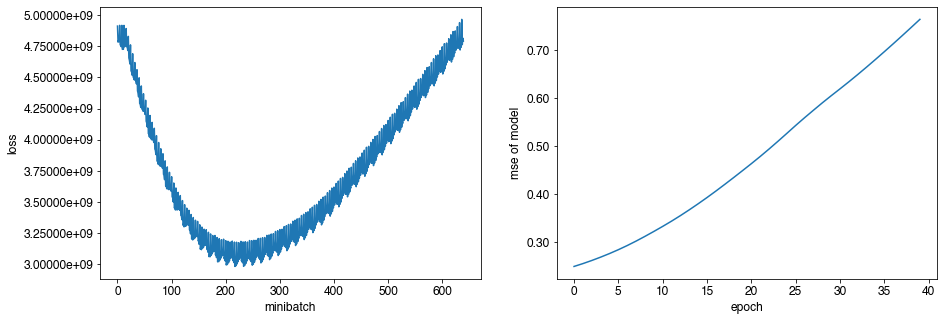

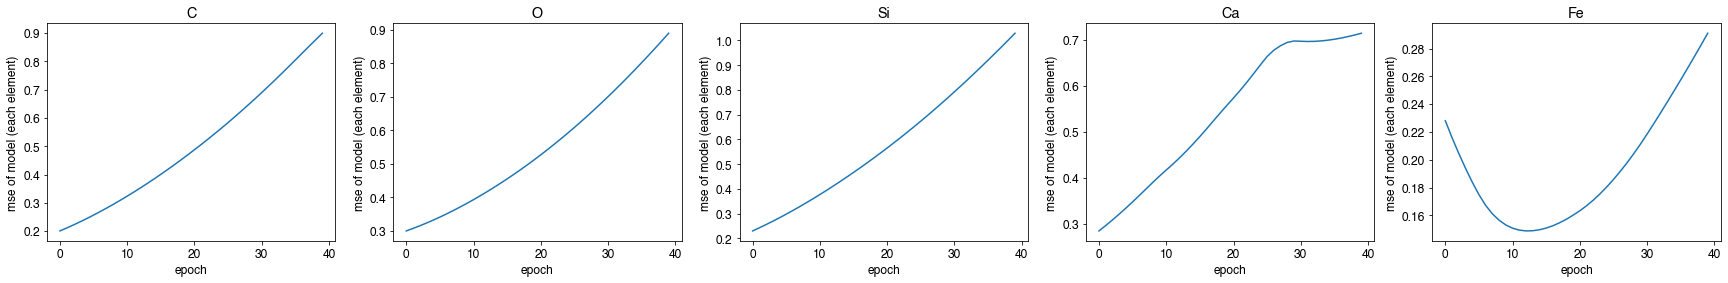

In [185]:
cont_from_check_point = False
use_saved_initial_guess = False

lr = 0.001
n_epoch = tc.tensor(40).to(dev)
b = 0.0

n_minibatch = tc.tensor(1).to(dev)                                               # this could be the number of threads run in parallel
minibatch_size = tc.tensor(25).to(dev)                                            # this could be the number of strips handled by one thread
n_batch = (sample_height_n * sample_size_n) // (n_minibatch * minibatch_size)    # this could be the number of parallel runs for a single object angle


y2_true = XRT_data.to(dev)
X_true = tc.from_numpy(np.load(os.path.join(grid_path, f_grid)).astype(np.float32)).to(dev)

if cont_from_check_point == False:
    if use_saved_initial_guess:
        X = np.load(os.path.join(recon_path, f_initial_guess)+'.npy')
        X = tc.from_numpy(X).float().to(dev)
        ## Save the initial guess which will be used in reconstruction and will be updated to the current reconstructing result
        np.save(os.path.join(recon_path, f_recon_grid)+'.npy', X)   
        
    else:
        X = initialize_guess_3d(ini_kind, grid_path, f_grid, recon_path, f_recon_grid, f_initial_guess, const=0.5)
            
     
    with open(os.path.join(recon_path, f_recon_parameters), "w") as recon_params:
        recon_params.write("starting_epoch = 0\n")
        recon_params.write("n_epoch = %d\n" %n_epoch)
        recon_params.write(str(this_aN_dic)+"\n") 
        recon_params.write("n_minibatch = %d\n" %n_minibatch)
        recon_params.write("b = %.9f\n" %b)
        recon_params.write("learning rate = %f\n" %lr)
        recon_params.write("theta_st = %.2f\n" %theta_st)
        recon_params.write("theta_end = %.2f\n" %theta_end)
        recon_params.write("n_theta = %d\n" %n_theta)
        recon_params.write("sample_size_n = %d\n" %sample_size_n)
        recon_params.write("sample_height_n = %d\n" %sample_height_n)
        recon_params.write("sample_size_cm = %.2f\n" %sample_size_cm)
        recon_params.write("probe_energy = %.2f\n" %probe_energy[0])
        recon_params.write("probe_cts = %.2e\n" %probe_cts)
        recon_params.write("det_size_cm = %.2f\n" %det_size_cm)
        recon_params.write("det_from_sample_cm = %.2f\n" %det_from_sample_cm)
        recon_params.write("det_ds_spacing_cm = %.2f\n" %det_ds_spacing_cm)
    
    loss_minibatch = tc.zeros(n_minibatch * n_batch * n_theta * n_epoch).to(dev)
    mse_epoch = tc.zeros(n_epoch, len(this_aN_dic)).to(dev)


    for epoch in tqdm(range(n_epoch)):
        for this_theta_idx, theta in enumerate(theta_ls):
    #         print("this_theta_idx = %d" %(this_theta_idx))
            y1_true = tc.from_numpy(np.load('./data/sample3_data/XRF_sample3_{}'.format(this_theta_idx)+'.npy').astype(np.float32))
        
            for m in range(n_batch):
                
                minibatch_ls = n_minibatch * m + tc.arange(n_minibatch)
                loss_fn = nn.MSELoss()
                
                if epoch == 0 and m == 0:
                    model = [PPM(ini_kind, const, X, p, len(this_aN_dic), sample_height_n, minibatch_size, sample_size_n, sample_size_cm,
                    this_aN_dic, probe_energy, probe_cts, fl_line_groups, fl_K, fl_L, fl_M, group_lines,
                    theta_st, theta_end, n_theta, this_theta_idx,
                    det_ds_spacing_cm, det_size_cm, det_from_sample_cm, P_save_path).to(dev) for p in minibatch_ls]
                
                else:
                    model = [PPM_cont(X, p, len(this_aN_dic), sample_height_n, minibatch_size, sample_size_n, sample_size_cm,
                    this_aN_dic, probe_energy, probe_cts, fl_line_groups, fl_K, fl_L, fl_M, group_lines,
                    theta_st, theta_end, n_theta, this_theta_idx,
                    det_ds_spacing_cm, det_size_cm, det_from_sample_cm, P_save_path).to(dev) for p in minibatch_ls]
                                
                for ip, p in enumerate(minibatch_ls):
                    optimizer = [tc.optim.Adam(model[ip].parameters(), lr=lr) for p in minibatch_ls]
                    
                    X = np.load(os.path.join(recon_path, f_recon_grid) + '.npy').astype(np.float32)
                    X = tc.from_numpy(X).to(dev)

                    y1_hat, y2_hat = model[ip](X, this_theta_idx)
                    XRF_loss = loss_fn(y1_hat, y1_true[:, minibatch_size * p : minibatch_size * (p+1)])
                    XRT_loss = loss_fn(y2_hat, y2_true[this_theta_idx,  minibatch_size * p : minibatch_size * (p+1)])

                    loss = XRF_loss + b * XRT_loss 
#                     loss = XRF_loss
        
                    loss_minibatch[(n_minibatch * n_batch * n_theta) * epoch + (n_minibatch * n_batch) * this_theta_idx + n_minibatch * m + ip] = loss

                    optimizer[ip].zero_grad()
                    loss.backward()
                    optimizer[ip].step()
                    
                    X_rot = rotate(X, theta, dev).view(n_element, sample_height_n * sample_size_n, sample_size_n)
                    X_rot[:, minibatch_size * p : minibatch_size*(p+1),:] = model[ip].xp
                    X_update = rotate(X_rot.view(n_element, sample_height_n, sample_size_n, sample_size_n), -theta, dev)  
                    X = tc.clamp(X_update, 0, 10)
                    
                    np.save(os.path.join(recon_path, f_recon_grid)+'.npy', X.detach().cpu().numpy())
                    
        mse_epoch[epoch] = tc.mean(tc.square(X - X_true).view(X.shape[0], X.shape[1]*X.shape[2]*X.shape[3]), dim=1)
        tqdm._instances.clear()   
        
    mse_epoch_tot = tc.mean(mse_epoch, dim=1)
    
    fig6 = plt.figure(figsize=(15,5))
    gs6 = gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1,1])

    fig6_ax1 = fig6.add_subplot(gs6[0,0])
    fig6_ax1.plot(loss_minibatch.detach().numpy())
    fig6_ax1.set_xlabel('minibatch')
    fig6_ax1.set_ylabel('loss')
    fig6_ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.5e'))
    
    fig6_ax2 = fig6.add_subplot(gs6[0,1])
    fig6_ax2.plot(mse_epoch_tot.detach().numpy())
    fig6_ax2.set_xlabel('epoch')
    fig6_ax2.set_ylabel('mse of model')
    fig6_ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    plt.savefig(os.path.join(recon_path, 'loss_and_tot_mse.pdf'))
    
    
    fig7 = plt.figure(figsize=(X.shape[0]*6, 4))
    gs7 = gridspec.GridSpec(nrows=1, ncols=X.shape[0], width_ratios=[1]*X.shape[0])
    for i in range(X.shape[0]):
        fig7_ax1 = fig7.add_subplot(gs7[0,i])
        fig7_ax1.plot(mse_epoch[:,i].detach().numpy())
        fig7_ax1.set_xlabel('epoch')
        fig7_ax1.set_ylabel('mse of model (each element)')
        fig7_ax1.set_title(str(list(this_aN_dic.keys())[i]))
#         fig7_ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))         
    plt.savefig(os.path.join(recon_path, 'mse_model.pdf'))
    
    np.save(os.path.join(recon_path, 'loss_minibatch.npy'), loss_minibatch.detach().numpy())  
    np.save(os.path.join(recon_path, 'mse_model.npy'), mse_epoch.detach().numpy()) 
    dxchange.write_tiff(X.detach().cpu().numpy(), os.path.join(recon_path, f_recon_grid)+"_"+str(idx), dtype='float32', overwrite=True)
    
if cont_from_check_point == True:
    idx += 1
    X = tc.from_numpy(np.load(os.path.join(recon_path, f_recon_grid)+'.npy')).float().to(dev)
        
    with open(os.path.join(recon_path, f_recon_parameters), "r") as recon_params:
        params_list = []
        for line in recon_params.readlines():
            params_list.append(line.rstrip("\n"))
        n_ending = len(params_list)
        
    with open(os.path.join(recon_path, f_recon_parameters), "a") as recon_params:
        n_start_last = n_ending - 17
        
        previous_epoch = int(params_list[n_start_last][params_list[n_start_last].find("=")+1:])   
        recon_params.write("\n")
        recon_params.write("###########################################\n")
        recon_params.write("starting_epoch = %d\n" %(previous_epoch + n_epoch))
        recon_params.write("n_epoch = %d\n" %n_epoch)
        recon_params.write(str(this_aN_dic)+"\n") 
        recon_params.write("n_minibatch = %d\n" %n_minibatch)
        recon_params.write("b = %f\n" %b)
        recon_params.write("learning rate = %f\n" %lr)
        recon_params.write("theta_st = %.2f\n" %theta_st)
        recon_params.write("theta_end = %.2f\n" %theta_end)
        recon_params.write("n_theta = %d\n" %n_theta)
        recon_params.write("sample_size_n = %d\n" %sample_size_n)
        recon_params.write("sample_height_n = %d\n" %sample_height_n)
        recon_params.write("sample_size_cm = %.2f\n" %sample_size_cm)
        recon_params.write("probe_energy = %.2f\n" %probe_energy[0])
        recon_params.write("probe_cts = %.2e\n" %probe_cts)
        recon_params.write("det_size_cm = %.2f\n" %det_size_cm)
        recon_params.write("det_from_sample_cm = %.2f\n" %det_from_sample_cm)
        recon_params.write("det_ds_spacing_cm = %.2f\n" %det_ds_spacing_cm)
    
    loss_minibatch_cont = tc.zeros(n_minibatch * n_batch * n_theta * n_epoch).to(dev)
    mse_epoch_cont = tc.zeros(n_epoch, len(this_aN_dic)).to(dev)

    for epoch in tqdm(range(n_epoch)):
        for this_theta_idx, theta in enumerate(theta_ls):
            y1_true = tc.from_numpy(np.load('./data/sample3_data/XRF_sample3_{}'.format(this_theta_idx)+'.npy').astype(np.float32))
        
            for m in range(n_batch):
                model = [PPM_cont(X, p, len(this_aN_dic), sample_height_n, minibatch_size, sample_size_n, sample_size_cm,
                this_aN_dic, probe_energy, probe_cts, fl_line_groups, fl_K, fl_L, fl_M, group_lines,
                theta_st, theta_end, n_theta, this_theta_idx,
                det_ds_spacing_cm, det_size_cm, det_from_sample_cm, P_save_path).to(dev) for p in minibatch_ls]
                                            
                for ip, p in enumerate(minibatch_ls):
                    optimizer = [tc.optim.Adam(model[ip].parameters(), lr=lr) for p in minibatch_ls]                   
                    X = np.load(os.path.join(recon_path, f_recon_grid) + '.npy').astype(np.float32)
                    X = tc.from_numpy(X).to(dev)

                    y1_hat, y2_hat = model[ip](X, this_theta_idx)
                    XRF_loss = loss_fn(y1_hat, y1_true[:, minibatch_size * p : minibatch_size * (p+1)])
                    XRT_loss = loss_fn(y2_hat, y2_true[this_theta_idx,  minibatch_size * p : minibatch_size * (p+1)])

                    loss = XRF_loss + b * XRT_loss 
#                     loss = XRF_loss
                    
                    loss_minibatch_cont[(n_minibatch * n_batch * n_theta) * epoch + (n_minibatch * n_batch) * this_theta_idx + n_minibatch * m + ip] = loss

                    optimizer[ip].zero_grad()
                    loss.backward()
                    optimizer[ip].step()
                    
                    X_rot = rotate(X, theta, dev).view(n_element, sample_height_n * sample_size_n, sample_size_n)
                    X_rot[:, minibatch_size * p : minibatch_size*(p+1),:] = model[ip].xp
                    X_update = rotate(X_rot.view(n_element, sample_height_n, sample_size_n, sample_size_n), -theta, dev)  
                    X = tc.clamp(X_update, 0, 10)
                    
                    np.save(os.path.join(recon_path, f_recon_grid)+'.npy', X.detach().cpu().numpy()) 
                    
        mse_epoch_cont[epoch] = tc.mean(tc.square(X - X_true).view(X.shape[0], X.shape[1]*X.shape[2]*X.shape[3]), dim=1)
        tqdm._instances.clear() 
        
    loss_minibatch = tc.cat((loss_minibatch, loss_minibatch_cont))
    mse_epoch = tc.cat((mse_epoch, mse_epoch_cont))
    
    fig6 = plt.figure(figsize=(15,5))
    gs6 = gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1,1])

    fig6_ax1 = fig6.add_subplot(gs6[0,0])
    fig6_ax1.plot(loss_minibatch.detach().numpy())
    fig6_ax1.set_xlabel('minibatch')
    fig6_ax1.set_ylabel('loss')
    fig6_ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.5e'))
    
    fig6_ax2 = fig6.add_subplot(gs6[0,1])
    fig6_ax2.plot(mse_epoch_tot.detach().numpy())
    fig6_ax2.set_xlabel('epoch')
    fig6_ax2.set_ylabel('mse of model')
    fig6_ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    plt.savefig(os.path.join(recon_path, 'loss_and_tot_mse.pdf'))
    
    
    fig7 = plt.figure(figsize=(X.shape[0]*6, 4))
    gs7 = gridspec.GridSpec(nrows=1, ncols=X.shape[0], width_ratios=[1]*X.shape[0])
    for i in range(X.shape[0]):
        fig7_ax1 = fig7.add_subplot(gs7[0,i])
        fig7_ax1.plot(mse_epoch[:,i].detach().numpy())
        fig7_ax1.set_xlabel('epoch')
        fig7_ax1.set_ylabel('mse of model (each element)')
        fig7_ax1.set_title(str(list(this_aN_dic.keys())[i]))
#         fig7_ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f')) 

    plt.savefig(os.path.join(recon_path, 'mse_model.pdf'))
    
    np.save(os.path.join(recon_path, 'loss_minibatch.npy'), loss_minibatch.detach().numpy())  
    np.save(os.path.join(recon_path, 'mse_model.npy'), mse_epoch.detach().numpy()) 
    dxchange.write_tiff(X.detach().cpu().numpy(), os.path.join(recon_path, f_recon_grid)+"_"+str(idx), dtype='float32', overwrite=True)

# Plot the reconstructed results

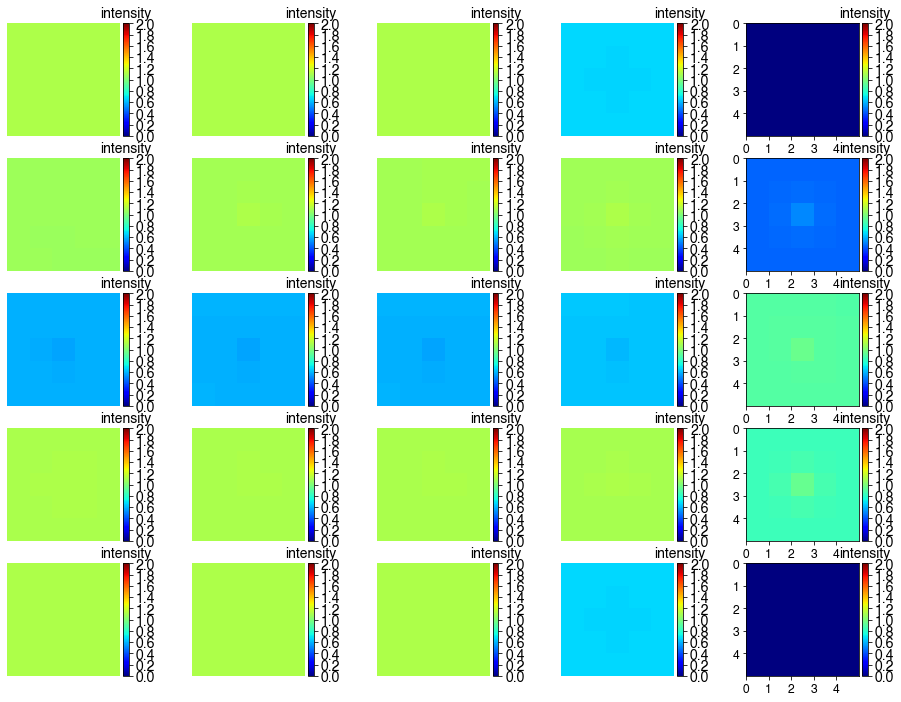

In [186]:
X = np.load(os.path.join(recon_path, f_recon_grid)+'.npy')
X = tc.tensor(X)

image_size = X.shape[-1]
fig6 = plt.figure(figsize=(4 * X.shape[0] * 0.8 , 3 * X.shape[1] * 0.8))
gs6 = gridspec.GridSpec(nrows=X.shape[1], ncols = X.shape[0], width_ratios=[1] * X.shape[0])

for layer_idx in range(X.shape[1]):
    fig6_ax1 = fig6.add_subplot(gs6[layer_idx,0])
    fig6_ax1.set_xticks(np.arange(0, image_size, 1))
    fig6_ax1.set_yticks(np.arange(0, image_size, 1))
    # fig6_ax1.grid(color='w', linewidth=2)
    fig6_ax1.axis('off')
    pos = fig6_ax1.imshow(X[0,layer_idx], cmap='jet', vmin=0, vmax=2.0, extent=[0, 5, 5, 0], origin='upper')
    divider = make_axes_locatable(fig6_ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
    cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
    cbar.ax.tick_params(labelsize=14) 
    cbar.ax.set_title('intensity', size='14')

    fig6_ax2 = fig6.add_subplot(gs6[layer_idx,1])
    fig6_ax2.set_xticks(np.arange(0, image_size, 1))
    fig6_ax2.set_yticks(np.arange(0, image_size, 1))
    # fig6_ax2.grid(color='w', linewidth=2)
    fig6_ax2.axis('off')
    pos = fig6_ax2.imshow(X[1,layer_idx], cmap='jet', vmin=0, vmax=2.0, extent=[0, 5, 5, 0], origin='upper')
    divider = make_axes_locatable(fig6_ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
    cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
    cbar.ax.tick_params(labelsize=14) 
    cbar.ax.set_title('intensity', size='14')

    fig6_ax3 = fig6.add_subplot(gs6[layer_idx,2])
    fig6_ax3.set_xticks(np.arange(0, image_size, 1))
    fig6_ax3.set_yticks(np.arange(0, image_size, 1))
    # fig6_ax3.grid(color='w', linewidth=2)
    fig6_ax3.axis('off')
    pos = fig6_ax3.imshow(X[2,layer_idx], cmap='jet', vmin=0, vmax=2.0, extent=[0, 5, 5, 0], origin='upper')
    divider = make_axes_locatable(fig6_ax3)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
    cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
    cbar.ax.tick_params(labelsize=14) 
    cbar.ax.set_title('intensity', size='14')

    fig6_ax4 = fig6.add_subplot(gs6[layer_idx,3])
    fig6_ax4.set_xticks(np.arange(0, image_size, 1))
    fig6_ax4.set_yticks(np.arange(0, image_size, 1))
    # fig6_ax4.grid(color='w', linewidth=2)
    fig6_ax4.axis('off')
    pos = fig6_ax4.imshow(X[3,layer_idx], cmap='jet', vmin=0, vmax=2.0, extent=[0, 5, 5, 0], origin='upper')
    divider = make_axes_locatable(fig6_ax4)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
    cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
    cbar.ax.tick_params(labelsize=14) 
    cbar.ax.set_title('intensity', size='14')

    fig6_ax5 = fig6.add_subplot(gs6[layer_idx,4])
    fig6_ax5.set_xticks(np.arange(0, image_size, 1))
    fig6_ax5.set_yticks(np.arange(0, image_size, 1))
    # fig6_ax5.grid(color='w', linewidth=2)
    # fig6_ax5.axis('off')
    pos = fig6_ax5.imshow(X[4,layer_idx], cmap='jet', vmin=0, vmax=2.0, extent=[0, 5, 5, 0], origin='upper')
    divider = make_axes_locatable(fig6_ax5)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
    cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
    cbar.ax.tick_params(labelsize=14) 
    cbar.ax.set_title('intensity', size='14')

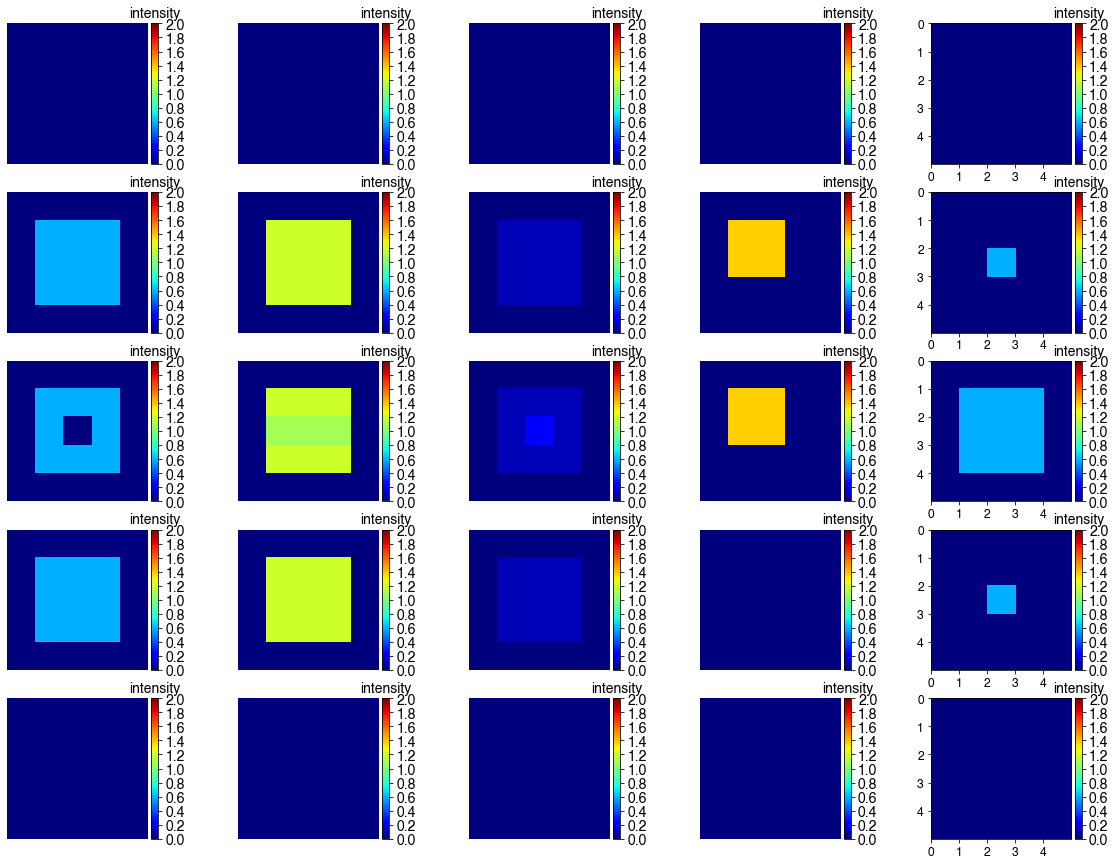

In [71]:
X = np.load(os.path.join(grid_path, f_grid))
X = tc.tensor(X)

image_size = X.shape[-1]
fig6 = plt.figure(figsize=(4 * X.shape[0] , 3 * X.shape[1]))
gs6 = gridspec.GridSpec(nrows=X.shape[1], ncols = X.shape[0], width_ratios=[1] * X.shape[0])

for layer_idx in range(X.shape[1]):
    fig6_ax1 = fig6.add_subplot(gs6[layer_idx,0])
    fig6_ax1.set_xticks(np.arange(0, image_size, 1))
    fig6_ax1.set_yticks(np.arange(0, image_size, 1))
    # fig6_ax1.grid(color='w', linewidth=2)
    fig6_ax1.axis('off')
    pos = fig6_ax1.imshow(X[0,layer_idx], cmap='jet', vmin=0, vmax=2.0, extent=[0, 5, 5, 0], origin='upper')
    divider = make_axes_locatable(fig6_ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
    cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
    cbar.ax.tick_params(labelsize=14) 
    cbar.ax.set_title('intensity', size='14')

    fig6_ax2 = fig6.add_subplot(gs6[layer_idx,1])
    fig6_ax2.set_xticks(np.arange(0, image_size, 1))
    fig6_ax2.set_yticks(np.arange(0, image_size, 1))
    # fig6_ax2.grid(color='w', linewidth=2)
    fig6_ax2.axis('off')
    pos = fig6_ax2.imshow(X[1,layer_idx], cmap='jet', vmin=0, vmax=2.0, extent=[0, 5, 5, 0], origin='upper')
    divider = make_axes_locatable(fig6_ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
    cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
    cbar.ax.tick_params(labelsize=14) 
    cbar.ax.set_title('intensity', size='14')

    fig6_ax3 = fig6.add_subplot(gs6[layer_idx,2])
    fig6_ax3.set_xticks(np.arange(0, image_size, 1))
    fig6_ax3.set_yticks(np.arange(0, image_size, 1))
    # fig6_ax3.grid(color='w', linewidth=2)
    fig6_ax3.axis('off')
    pos = fig6_ax3.imshow(X[2,layer_idx], cmap='jet', vmin=0, vmax=2.0, extent=[0, 5, 5, 0], origin='upper')
    divider = make_axes_locatable(fig6_ax3)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
    cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
    cbar.ax.tick_params(labelsize=14) 
    cbar.ax.set_title('intensity', size='14')

    fig6_ax4 = fig6.add_subplot(gs6[layer_idx,3])
    fig6_ax4.set_xticks(np.arange(0, image_size, 1))
    fig6_ax4.set_yticks(np.arange(0, image_size, 1))
    # fig6_ax4.grid(color='w', linewidth=2)
    fig6_ax4.axis('off')
    pos = fig6_ax4.imshow(X[3,layer_idx], cmap='jet', vmin=0, vmax=2.0, extent=[0, 5, 5, 0], origin='upper')
    divider = make_axes_locatable(fig6_ax4)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
    cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
    cbar.ax.tick_params(labelsize=14) 
    cbar.ax.set_title('intensity', size='14')

    fig6_ax5 = fig6.add_subplot(gs6[layer_idx,4])
    fig6_ax5.set_xticks(np.arange(0, image_size, 1))
    fig6_ax5.set_yticks(np.arange(0, image_size, 1))
    # fig6_ax5.grid(color='w', linewidth=2)
    # fig6_ax5.axis('off')
    pos = fig6_ax5.imshow(X[4,layer_idx], cmap='jet', vmin=0, vmax=2.0, extent=[0, 5, 5, 0], origin='upper')
    divider = make_axes_locatable(fig6_ax5)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
    cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
    cbar.ax.tick_params(labelsize=14) 
    cbar.ax.set_title('intensity', size='14')